# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs
from helper import *

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [2]:
# Describe numeric data
display(data.describe(include=[np.number]))

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


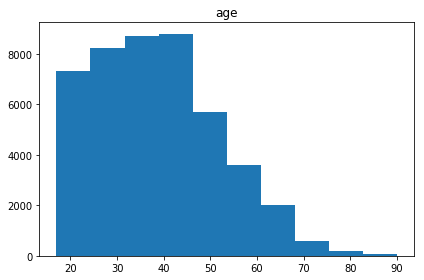

In [3]:
visualize_distribution_of(data, 'age')

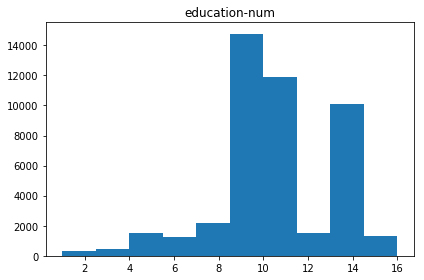

In [4]:
visualize_distribution_of(data, 'education-num')

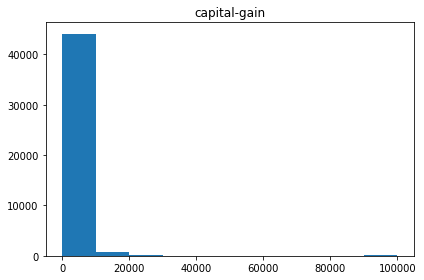

In [5]:
visualize_distribution_of(data, 'capital-gain')

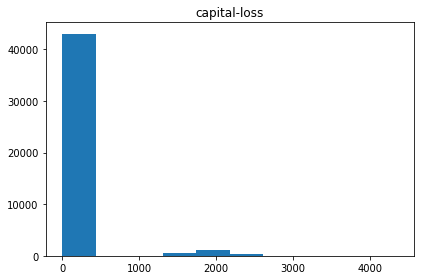

In [6]:
visualize_distribution_of(data, 'capital-loss')

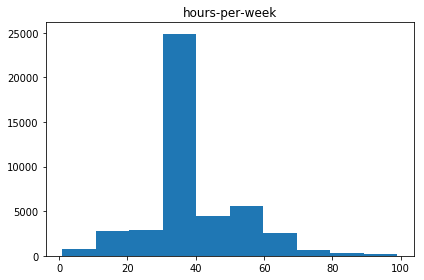

In [7]:
visualize_distribution_of(data, 'hours-per-week')

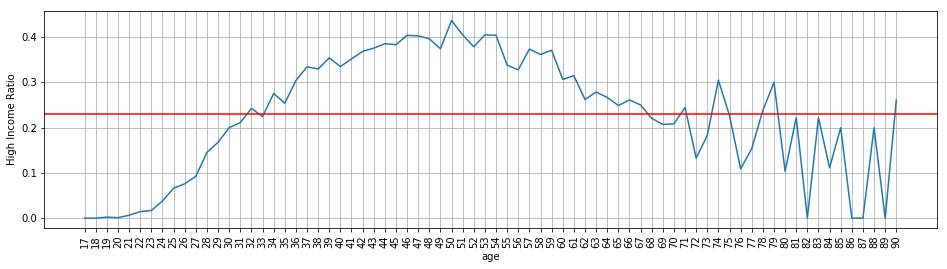

In [8]:
plot_income_ratio_by(data, 'age')

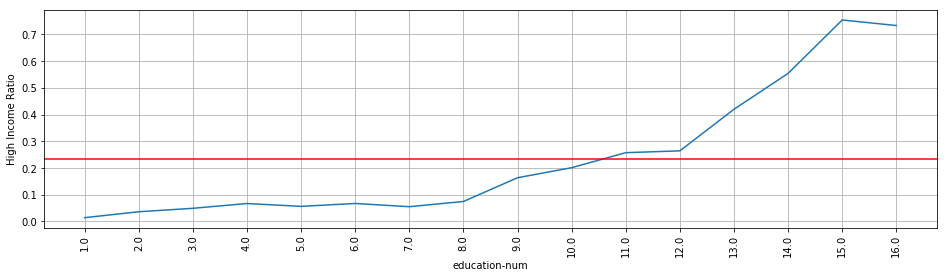

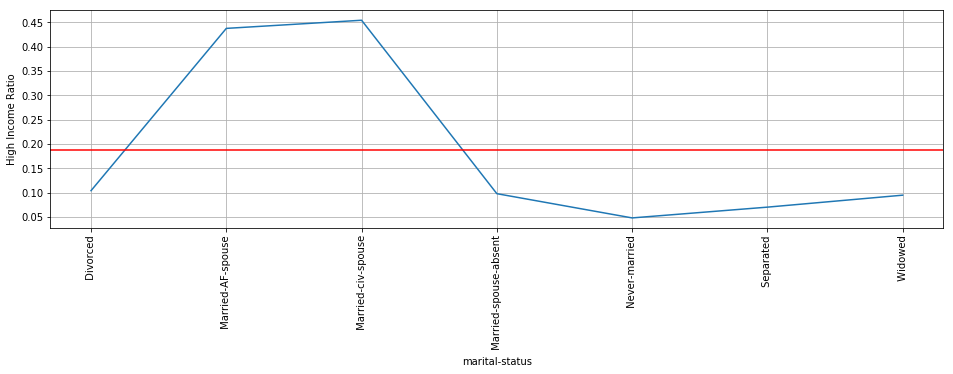

In [9]:
plot_income_ratio_by(data, 'education-num')
plot_income_ratio_by(data, 'marital-status')

In [10]:
# Describe categorial data
display(data.describe(include=[object]))

,workclass,education_level,marital-status,occupation,relationship,race,sex,native-country,income
count,45222,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,33307,14783,21055,6020,18666,38903,30527,41292,34014


Do this dataset have a gender bias?

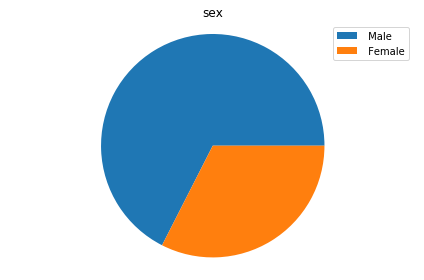

In [11]:
pie_chart_for(data, 'sex')

It seems so. For a 1994 census, if we consider that the majority of datapoints are "householders", the disparity makes sense.

What about `marital-status` and `relationship` then? They must be .... related (pun intended).

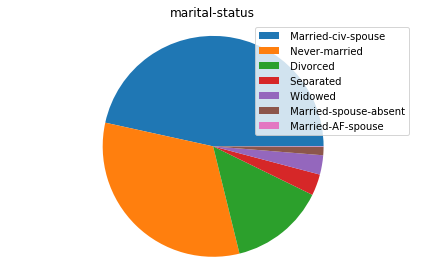

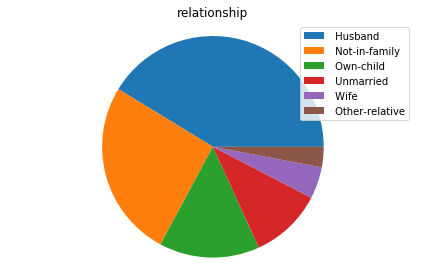

In [12]:
pie_chart_for(data, 'marital-status')
pie_chart_for(data, 'relationship')

First, we need to understand what these values really mean, as the categories' names, putting it mildly, are not very readable sometimes.

For `marital-status`, look in [here](https://www.census.gov/prod/2011pubs/p70-125.pdf) and [here](https://www.census.gov/programs-surveys/cps/technical-documentation/subject-definitions.html).

For `relationship`, we have:
- `Husband`: Inside a marriage as the husband
- `Wife`: Inside a marriage as the wife
- `Own-child`: Living with parents (*)
- `Unmarried`: Not married, living with children (*)
- `Not-in-family`: Not married and living with no children (*)

We can see that the count of `Married-*` is aprox. equal to the count of `Husband + Wife`, as expected.

(*) I'm not sure about those. It's a GUESS based on the proportion of people of this class that are above 50K and gender proportion. See the numbers on the cell below.

In [13]:
_, own_child_incomes = np.unique(data[data.relationship==' Own-child'].income, return_counts=True)
_, not_in_family_incomes = np.unique(data[data.relationship==' Not-in-family'].income, return_counts=True)
_, unmarried_incomes = np.unique(data[data.relationship==' Unmarried'].income, return_counts=True)
_, not_in_family_sex = np.unique(data[data.relationship==' Not-in-family'].sex, return_counts=True)
_, unmarried_sex = np.unique(data[data.relationship==' Unmarried'].sex, return_counts=True)

print('Own-child above 50K: {:.2f}%'.format(percentualize(own_child_incomes)[1]))
print('Unmarried sex propotion (F-M): {}'.format(percentualize(unmarried_sex)))
print('Not-in-family above 50K: {:.2f}%'.format(percentualize(not_in_family_incomes)[1]))
print('Not-in-family sex propotion (F-M): {}'.format(percentualize(not_in_family_sex)))

husband_or_wife_count = data.relationship.isin([' Husband', ' Wife']).sum()
married_count = data['marital-status'].isin([' Married-civ-spouse', ' Married-AF-spouse']).sum()
print('\nHusband or Wife: {}'.format(husband_or_wife_count))
print('Married-*: {}'.format(married_count))

male_wife_count = ((data.relationship == ' Wife') & (data.sex == ' Male')).sum()
female_husband_count = ((data.relationship == ' Husband') & (data.sex == ' Female')).sum()
print('\nMale Wives: {}'.format(male_wife_count))
print('Female Husbands: {}'.format(female_husband_count))

display(pd.crosstab(data['marital-status'], data['relationship']))

Own-child above 50K: 1.58%
Unmarried sex propotion (F-M): [ 76.29490393  23.70509607]
Not-in-family above 50K: 10.49%
Not-in-family sex propotion (F-M): [ 46.24850453  53.75149547]

Husband or Wife: 20757
Married-*: 21087

Male Wives: 1
Female Husbands: 1


relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
marital-status,,,,,,
Divorced,0,3435,166,429,2267,0
Married-AF-spouse,11,0,1,1,0,19
Married-civ-spouse,18655,19,184,125,0,2072
Married-spouse-absent,0,282,44,57,169,0
Never-married,0,6691,820,5864,1223,0
Separated,0,588,75,130,618,0
Widowed,0,687,59,20,511,0


There is something strange going on the `Married-spouse-absent` row. According to the description:

`The group "married, spouse absent" includes married people living apart because either the husband or wife was employed and living at a considerable distance from home, was serving away from home in the Armed Forces, had moved to another area`

It is funny to see that there is a non-zero value at the `Unmarried` column. My interpretation on this is that the spouse lives in another house and the subject lives with children.

Another interesting observation is the existence of Male Wives and Female Husbands. Could it be same-sex couples?

Now, let us look at `education_level` and `education-num`. They both describe a degree of schooling. How do they relate to each other?

In [14]:
display(pd.crosstab(data['education_level'], data['education-num']))

education-num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
education_level,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,1223,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1619,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,577,0,0,0,0,0,0,0,0
1st-4th,0,222,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,449,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,823,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,676,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1507,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1959,0,0,0,0,0


Whoa! `education_level` does not add any information at all. Being an integer, `education-num` also gives us an ordering that `education_level` does not.

Our next stop is the `native-country` feature. This categorical features has much more levels than others - maybe we find something interesting to help our model. Let's start by plotting income distribution by country.

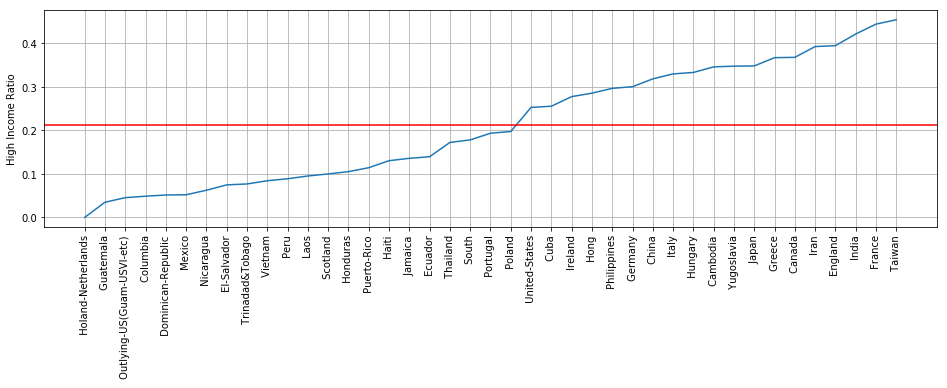

In [15]:
table = pd.crosstab(data['native-country'], data['income'])
col_sum = table.sum(axis=1)
high_income_ratio = table.divide(col_sum,axis=0)['>50K'].sort_values()
x = range(len(high_income_ratio))

# Plot the high income ratio per country chart
plt.figure(figsize=(16,4))
plt.ylabel('High Income Ratio')
plt.xticks(x, high_income_ratio.index, rotation=90)
plt.plot(x, high_income_ratio.values)
plt.axhline(y=high_income_ratio.values.mean(), c='red')
plt.grid()
plt.show()

The red line points to the average income ratio, separating the countries in two interesting portions. Below the line, there is a majority of Latin American countries. The first country above the line is USA itself, taking a big leap from Poland on the left.

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [16]:
from __future__ import division

# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = (data.income == '>50K').sum()

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = (data.income == '<=50K').sum()

assert n_records == n_greater_50k + n_at_most_50k

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k / (n_greater_50k + n_at_most_50k) 

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

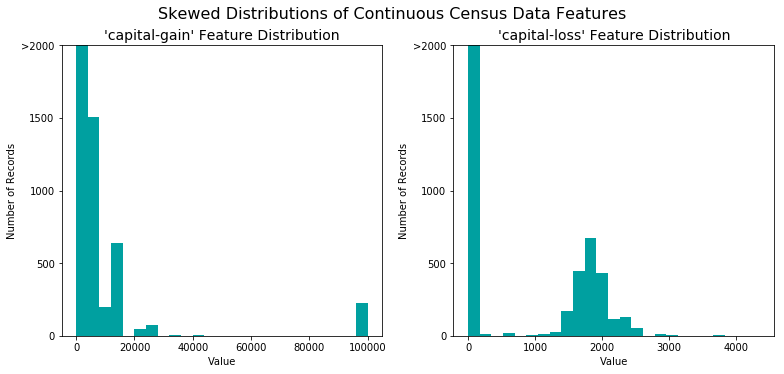

In [17]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

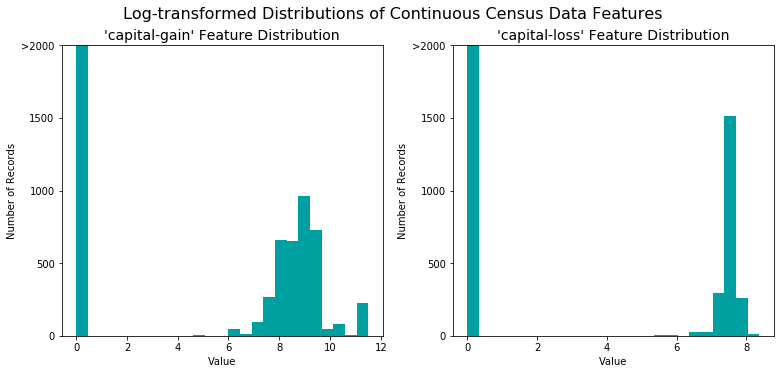

In [18]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [19]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [20]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = (income_raw == '>50K').astype(int)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
# display(features.head(n=1))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [21]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [22]:
from sklearn.metrics import accuracy_score, fbeta_score

# Calculate accuracy
accuracy = accuracy_score(income, [1] * len(income))

# Calculate F-score using the formula above for beta = 0.5
fscore = fbeta_score(income, [1] * len(income), 0.5)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

Before we choose one, let's take a look at the structure of the data using `TSNE`.

In [23]:
# indices = np.random.choice(np.arange(len(features)), 1000, replace=False)
# plot_tsne(plt, features.iloc[indices], income[indices], 50)

# Uncomment above to see 2D plot of data

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

The idea in choosing the model is to start with simple ones that might perform somewhat well on the data and move to more complicated ones (Occam's razor in action here). Also, diversity is important to make sure we are looking at the problem from different angles.

** Decision Trees **

Decision Trees are useful for [credit-scoring](http://www.knowledgetaiwan.org/ojs/index.php/ijbi/article/download/77/35), among [other applications](http://www.cbcb.umd.edu/~salzberg/docs/murthy_thesis/survey/node32.html), and are known for the ease of training on large datasets, capability of handling both numerical and categorical data, extensibility for multiclass problems, dealing with nonlinear decision boundaries and interpretability.
The problem with decision trees is that they too much attention to the data and tend to produce very complicated decision boundaries (overfitting), specially when classes are not axis-aligned. Prunning may be employed, but it may become difficult for the prunned tree to explain the training data effectively.
Decision Trees are a good starting point for the problem as they offer some insight into the data, are quick to train and, after hyper-parameter selection, can become good baseline models.
This model is a good candidate for the problem because we don't have to worry about having both numeric and categorical features or even feature scaling. Also, we can inspect the model and compare with our understanding of the problem.


** Random Forest **

Random Forest have received a lot of attention in the field of [computer vision](http://pages.iai.uni-bonn.de/frintrop_simone//BVW13/BVW-gall.pdf) to predict, for example, handwritten digits or facial features in a face photograph.
Random Forests are very versatile, performing well on a variety of problems and offer a good starting point when not much is known about the data. They are able achieve balance between bias and variance by using bagging and subsetting features for each tree that is built (which reduces correlation between trees).
Another key aspect of Random Forests is their capability of dealing with unimportant features, which turns to be a problem with Decision Trees (see above). Some even use them solely for [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-as-part-of-a-pipeline)!
Unfortunately, they are not very interpretable: it is possible to see what features are deemed important, but that is all. Also, Random Forest will struggle with classes that are not axis-aligned (as Decision Trees do) or when the data is sparse (because of feature subsetting).
This model is a good candidate for the problem reasons similar to those of Decision Trees (interpretability to a lesser degree) with the advantages of increased predictive power and built-in feature selection mechanism.


** K-Nearest Neighbors **

K-Nearest neighbors have been used in [behavioral targeting](https://en.wikipedia.org/wiki/Nearest_neighbor_search#Applications) to predict, for example, which ad is most likely to be clicked by a customer, based on previous activity of himself and others.
Being non-parametric, K-Nearest Neighbors can represent arbitrarily complex functions and are known for its simplicity. It can deal with multiclass problems without needing any adjustment and can incorporate special domain knowledge by using a distance function tailored to the problem.
K-NN is a lazy learner, which means that almost no effort is done until we are prompted to estimate something. This is advantageous in settings where training the model is more common than querying it, but disadvantageous in the opposite scenario. Also, K-NN does not work well in high-dimensional problems due to the Curse of Dimensionality, although we can mitigate this using by dimensionality reduction techniques such as PCA.
At a first glance, the model is not a good candidate for the problem, after all, the dimensionality may be too high due to one-hot encoded variables, but the low-dimensional embedding of the data shows some promise.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [24]:
import functools
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    f_score = functools.partial(fbeta_score, beta=0.5)
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = f_score(y_train[:300], predictions_train)
        
    # Compute F-score on the test set
    results['f_test'] = f_score(y_test, predictions_test)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

DecisionTreeClassifier trained on 452 samples.
DecisionTreeClassifier trained on 4522 samples.
DecisionTreeClassifier trained on 45222 samples.
RandomForestClassifier trained on 452 samples.
RandomForestClassifier trained on 4522 samples.
RandomForestClassifier trained on 45222 samples.
KNeighborsClassifier trained on 452 samples.
KNeighborsClassifier trained on 4522 samples.
KNeighborsClassifier trained on 45222 samples.


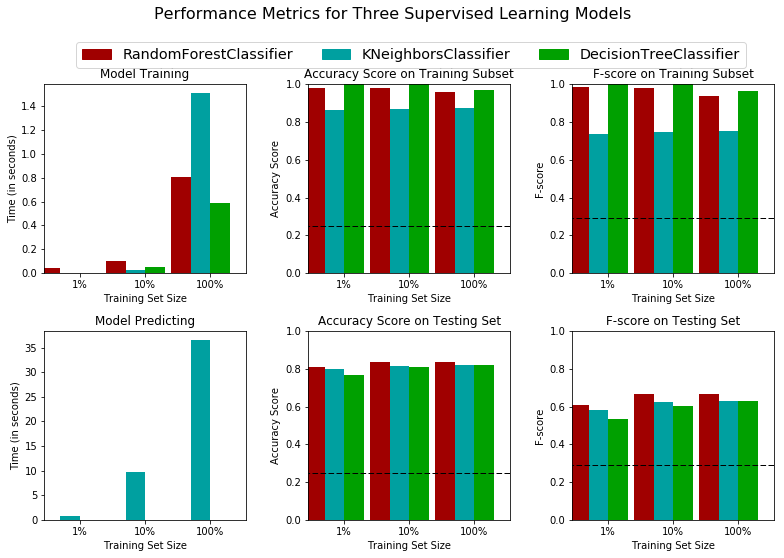

In [ ]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf_A = DecisionTreeClassifier(random_state=4213)
clf_B = RandomForestClassifier(random_state=4213)
clf_C = KNeighborsClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1, samples_10, samples_100 = (np.array([0.01, 0.1, 1.0]) * len(data)).astype(int)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)
        #print(results[clf_name][i])
            
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.* 

**Answer: **

Before we dive into the analysis, consider this: once trained, a model will be used to make thousands (even more) predictions, so prediction time weights heavily when choosing the model.
Suppose CharityML wants to make a prediction for every household on US. According to 2016 US Census, we have aprox. 126 million households. Also according to US Census, aprox. 80\% of US population live in Urban Areas, which gives us about 100 million households.

The first one we should rule out is KNN:
- Prediction time exceeds other models by a large factor, making it impractical for being used
- By looking at the F-score on training set, we can expect an upper bound of aproximately 0.75 to the model score on test data

The second one we should rule out is Decistion Tree:
- Faster than Random Forest (almost 4 times faster when predicting), it would take 100M * 0.01 = 1,000,000 seconds or 278 hours (against 1055 hours of Random Forest) to predict income for 100 million households. Using `c4.xlarge` EC2 instances, Decision Tree would would save 158 dollars when compared to Random Forest
- When comparing the `f_test` metric to RF, we observe a 5% decrease meaning that more money would be lost on a) mailing households with low chances of donation and b) missing a potential donor

This leaves us with `Random Forest`, our winner. We make a conscious choice of trading predicting speed and interpretability of decision trees to achieve better predictions with RF.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
Imagine you had to develop a set of simple questions to predict if a person's income was above 50K using only the data you have available (age, gender, etc). After some questions, you arrive at a conclusion and make a prediction. This technique is called Decision Tree and the training of a Decision Tree refers to the process of finding a set of questions that yield correct predictions for the presented data as much as possible.

Decision Trees are known to stick to training data too much and the process of training multiple trees helps the model prevent this behavior and generalize better on unseen data. A Random Forest takes this concept further by creating several sets of questions (Decision Trees) based on random subsets of the presented data. Prediction is obtained by making each of these trees cast a vote on the prediction they believe is the right one and choosing the prediction with most votes.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [ ]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=4213)

# TODO: Create the parameters list you wish to tune
parameters = {
    'n_estimators': [127],
    'max_depth': [15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
kfolds = StratifiedKFold(y_train, 3, True, 1337)
grid_obj = GridSearchCV(clf, parameters, scorer, n_jobs=-1, cv=kfolds)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

In [ ]:
print("Best parameters:")
print(grid_fit.best_params_)

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              | 0.8357            | 0.8597          |
| F-score        | 0.2917              | 0.6677            | 0.7339          |


**Answer: **
The baseline predictor works as a sanity check to see if our models provide any improvement at all. As expected, both Accuracy and F-score are better on the model we chose. Also, the optimized model performed better in both metrics than the unoptimized one, again, as expected.
Because of our choice of using F0.5 as the scoring function, the optimized model did not improve much on accuracy when compared to the unoptimized one but we can see a big improvement on F-score, meaning that the optimized model favored precision over recall (twice as much, in fact).

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

The ranking is based on the features that I believe are the most informative by themselves.
1. `capital-gain`: Capital Gain is a matter of how much you invest in the first place. People with big investments are most likely the ones with big paychecks in the first place
2. `capital-loss`: Same as above, but with the opposite outcome. For one to have a lot of capital loss, big investments are required
3. `occupation`: Some occupations are very likely to be well-paid, such as manager and executive. Others, on the hand, are very likely to be poorly-paid, such as cleaning-related jobs
4. `age`: Looking at the plot **High income ratio vs age**, it is possible to see that age plays an important role on the dependent variable. As people age and become more experienced at their trade, income increases. This trend goes until the age of 50, where income starts to decline. Knowing where a person sits in the timeline, thus, is important to their problem
5. `education-num`: People that spent more years studying qualify for better-paying jobs. We can verify that by looking at the plot **High income ratio vs education-num**

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [ ]:
# best_params = {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 127}

# Train the supervised model on the training set 
model = RandomForestClassifier(**grid_fit.best_params_).fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Print 10 most important features
print("Most important features:")
display(most_important(model, features.columns, 10))

# Plot
vs.feature_plot(importances, X_train, y_train)

In [ ]:
def importance_for(feature_prefix):
    # Importance for the whole feature, instead of importance for a single value
    importances = most_important(model, features.columns, 200)
    total_importance = sum(weight for feature, weight in importances if feature.startswith(feature_prefix))
    print("Importance for {}: {}".format(feature_prefix, total_importance))
    

importance_for('marital-status')
importance_for('relationship')
importance_for('occupation')
importance_for('education_level')
importance_for('sex')
importance_for('workclass')
importance_for('native-country')
importance_for('race')

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

`capital-gain`, `education-num` and `age` were considered important by both me and RF, confirming some of my beliefs.

`capital-loss` and `occupation` appear in the top 10. They have some importance, but much less than I presumed. Possible explanation for `capital-loss`: lack of non-zero entries - maybe people with high income are less likely to lose capital than gaining. Possible explanation for `occupation`: too fine-grained or unreliable.

`marital-status` and `relationship` are closely related (see table in **Exploring the Data**), more so for `marital-status_ Married-civ-spouse` and `relationship_ Husband`. One possible explanation is that married households may have double income, thus exceeding the 50K mark. In married households, the majority of householders are husbands, explaining the remaining feature `relationship_ Husband`.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start = time() # Get start time
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time() # Get end time
train_time_reduced = end - start

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

start = time() # Get start time
(clone(best_clf)).fit(X_train, y_train)
end = time() # Get end time
train_time = end - start

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "Training time: {:.4f} seconds".format(train_time)
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "Training time: {:.4f} seconds".format(train_time_reduced)

### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

The table below shows that the reduced model performs better than the Unoptmized Model. Great!

|     Metric     | Reduced Model       | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | **0.8446**          | 0.8357            | 0.8597          |
| F-score        | **0.6906**          | 0.6677            | 0.7339          |


As for the training time, it was cut to less than half with only a 5.9% drop in F-score. If training time was a factor, I would consider reducing data dimensionality on the training set.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.